In [1]:
%pip install mesa
#Importar clases necesarias para manejar agentes (Agent) y su entorno (Model)
from mesa import Agent, Model

#RandomActivation hace que los agentes se "Activen al mismo tiempo"
from mesa.time import SimultaneousActivation

from mesa.space import SingleGrid

from mesa.datacollection import DataCollector

from mesa.batchrunner import batch_run

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["animation.embed_limit"] = 2**128
import seaborn as sns

import numpy as np
import pandas as pd

import math

In [2]:
class WarehouseAgent(Agent):

  def __init__(self, id, model):
    super().__init__(id,model)
    self.id = id
    self.holding = False
    self.steps_moving = 0
    self.sorted = 0
    self.efficiency = 0

  def step(self):
    if not self.model.running:
      return

    neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    acting = False
    chX, chY = self.random.choice(neighbors)

    #Repite mientras no haya actuado y tenga vecinos para revisar
    while not acting and neighbors:
      #Selecciona una ubicación al azar para revisar y la elimina de la lista de posibles
      chX, chY = self.random.choice(neighbors)
      neighbors = [x for x in neighbors if x != (chX, chY)]

      #Si la celda está vacía hace el resto de comprobaciones
      if self.model.grid.is_cell_empty((chX, chY)):
        #Si hay solo una caja y el agente no tiene nada toma la caja
        if self.model.boxes[chX][chY] > 0 and self.model.boxes[chX][chY] < 5 and not self.holding:
          self.model.boxes[chX][chY] -= 1
          self.holding = True
          acting = True
        #Si en el espacio tiene al menos una caja, el agente tiene una caja y la pila es menor a 5 deja la caja
        elif self.model.boxes[chX][chY] > 0 and self.holding and self.model.boxes[chX][chY] < 5:
          self.model.boxes[chX][chY] += 1
          self.holding = False
          self.sorted += 1
          acting = True
        #Si no tiene una caja me muevo
        elif self.model.boxes[chX][chY] == 0:
          self.model.grid.move_agent(self, (chX, chY))
          self.steps_moving += 1
          acting = True

    if (self.steps_moving < 1):
      self.efficiency = self.sorted
    else:
      self.efficiency = self.sorted / self.steps_moving

In [3]:
class WarehouseModel(Model):
  def __init__(self, height, width, num_agents=5, num_boxes=100):
    super().__init__()
    self.total_boxes = num_boxes
    self.running = True
    self.steps = 0

    self.grid = SingleGrid(width, height, torus=False)
    self.schedule = SimultaneousActivation(self)
    self.datacollector = DataCollector(model_reporters={"Grid":get_grid,
                                                        "Steps":"steps"},
                                         agent_reporters={"Efficiency":"efficiency"})

    self.boxes = np.zeros((height, width))
    #Calcula las celdas sucias
    for i in range(num_boxes):
      assigned = False
      x = self.random.randrange(width)
      y = self.random.randrange(height)
      while not assigned:
        if self.boxes[x][y] == 0:
          self.boxes[x][y] = 1
          assigned = True
        else:
          x = self.random.randrange(width)
          y = self.random.randrange(height)

    #Crea los agentes
    for i in range(num_agents):
      agent = WarehouseAgent(i, self)
      self.grid.move_to_empty(agent)
      self.schedule.add(agent)

  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()
    if np.count_nonzero(self.boxes == 5) == (self.total_boxes / 5):
      self.running = False
    else:
      self.steps += 1

In [4]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    for content, (x,y) in model.grid.coord_iter():
        if content != None:
          grid[x][y] = 1
        elif model.boxes[x][y] > 0:
          grid[x][y] = model.boxes[x][y] + 1
    return grid

In [8]:
class WarehouseAgent2(Agent):

  def __init__(self, id, model):
    super().__init__(id,model)
    self.id = id
    self.holding = False
    self.steps_moving = 0
    self.sorted = 0
    self.efficiency = 0
    self.returnX = False
    self.returnY = False
    self.home = None

  def step(self):
    if not self.model.running:
      return

    if self.home != None:
      homeX, homeY = self.home
      if self.model.boxes[homeX][homeY] >= 5:
          self.home = None

    if not self.holding or self.home == None:
      self.search()
    else:
      self.findHome()

    if (self.steps_moving < 1):
      self.efficiency = self.sorted
    else:
      self.efficiency = self.sorted / self.steps_moving

  def search(self):
    neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    acting = False
    chX, chY = (-1, -1)
    first = (-1, -1)

    #Repite mientras no haya actuado y tenga vecinos para revisar
    while not acting and neighbors:
      #Selecciona una ubicación al azar para revisar y la elimina de la lista de posibles
      chX, chY = self.random.choice(neighbors)
      neighbors = [x for x in neighbors if x != (chX, chY)]

      #Si la celda está vacía hace el resto de comprobaciones
      if self.model.grid.is_cell_empty((chX, chY)):
        #Guardo la primera posición seleccionada si no he guardado una antes y está vacía
        if first == (-1, -1) and self.model.boxes[chX][chY] == 0:
          first = (chX, chY)
        #Si no ha guardado una caja para hacer de home y home está vacío la guarda como home
        if self.model.boxes[chX][chY] > 0 and self.model.boxes[chX][chY] < 5 and self.home == None:
          self.home = (chX, chY)
        #Si hay una caja diferente a home la toma y no está sosteniendo nada toma una caja
        elif self.model.boxes[chX][chY] > 0 and self.model.boxes[chX][chY] < 5 and (chX, chY) != self.home and not self.holding:
          self.model.boxes[chX][chY] -= 1
          self.holding = True
          acting = True
        #Si no puede tomar ninguna caja pone una posición en chX y chY
        elif not neighbors:
          chX, chY = first

    #chX y chY son mayores o iguales a 0 cuando tienen una coordenada válida guardada y no se hizo ninguna acción
    if chX >= 0 and chY >= 0 and self.model.grid.is_cell_empty((chX, chY)) and not acting and (chX, chY) != self.home:
      self.model.grid.move_agent(self, (chX, chY))
      self.steps_moving += 1

  def findHome(self):
    py,px = self.pos
    hy,hx = self.home

    distX = hx - px
    distY = hy - py

    if abs(distX) >= abs(distY):
      if distY == 0:
        distY = 1
      self.moveDir(int(abs(distX) / distX), 0, int(abs(distY) / distY))
      # if distX == 0:
      #   self.moveDir(0, 0, int(abs(distY) / distY))
      # else:
      #
    elif abs(distX) < abs(distY):
      if distX == 0:
        distX = 1
      self.moveDir(0, int(abs(distY) / distY), int(abs(distX) / distX))

  def moveDir(self, x, y, backup_mag):
    py,px = self.pos

    if abs(x) > abs(y) and self.model.grid.is_cell_empty((py, px + x)):
      #Si la posición siguiente es home haz las revisiones para home
      if (py, px + x) == self.home:
          self.checkHome(py, px + x)
      else:
        #Si la posición está dentro del rango del espacio
        if (px + x) < self.model.grid.width and (px + x) >= 0:
          #Si la posición está disponible y no me he movido hacia atrás me muevo a esa posición
          if self.model.boxes[py][px + x] == 0 and self.model.grid.is_cell_empty((py, px + x)) and not self.returnX:
            self.model.grid.move_agent(self, (py, px + x))
            self.steps_moving += 1
          #Si la posición no estaba disponible me muevo en la dirección de repuesto y si me había regresado muestro que ya me moví hacia atrás
          elif (py + backup_mag) >= 0 and (py + backup_mag) < self.model.grid.width and self.model.boxes[py + backup_mag][px] == 0 and self.model.grid.is_cell_empty((py + backup_mag, px)):
            if self.returnX:
              self.returnX = False
            self.model.grid.move_agent(self, (py + backup_mag, px))
            self.steps_moving += 1
          #Lo mismo que el anterior, pero en caso de que la dirección inicial esté ocupada
          elif (py - backup_mag) >= 0 and (py - backup_mag) < self.model.grid.width and self.model.boxes[py - backup_mag][px] == 0 and self.model.grid.is_cell_empty((py - backup_mag, px)):
            if self.returnX:
              self.returnX = False
            self.model.grid.move_agent(self, (py - backup_mag, px))
            self.steps_moving += 1
          #Si todo falló regreso una posición y marco que regresé para la siguiente comprobación
          elif self.model.boxes[py][px + x] > 0 or not self.model.grid.is_cell_empty((py, px + x)):
            if (px - x) >= 0 and (px - x) < self.model.grid.width and self.model.grid.is_cell_empty((py, px - x)) and self.model.boxes[py][px - x] == 0:
              self.model.grid.move_agent(self, (py, px - x))
              self.returnX = True
              self.steps_moving += 1
        else:
          #Si no me muevo una posición en el eje opuesto hacia adentro del espacio
          if (py - backup_mag) >= 0 and (py - backup_mag) < self.model.grid.width and self.model.boxes[py +- backup_mag][px] == 0 and self.model.grid.is_cell_empty((py - backup_mag, px)):
            self.model.grid.move_agent(self, (py - backup_mag, px))
          elif (py + backup_mag) >= 0 and (py + backup_mag) < self.model.grid.width and self.model.boxes[py + backup_mag][px] == 0 and self.model.grid.is_cell_empty((py + backup_mag, px)):
            self.model.grid.move_agent(self, (py + backup_mag, px))

    elif abs(x) < abs(y) and self.model.grid.is_cell_empty((py + y, px)):
      #Si la posición siguiente es home haz las revisiones para home
      if (py + y, px) == self.home:
        self.checkHome(py + y, px)
      else:
        #Si la posición está dentro del rango del espacio
        if (py + y) < self.model.grid.width and (py + y) >= 0:
          #Si la posición está disponible y no me he movido hacia atrás me muevo a esa posición
          if self.model.boxes[py + y][px] == 0 and self.model.grid.is_cell_empty((py + y, px)) and not self.returnY:
            self.model.grid.move_agent(self, (py + y, px))
            self.steps_moving += 1
          #Si la posición no estaba disponible me muevo en la dirección de repuesto y si me había regresado muestro que ya me moví hacia atrás
          elif (px + backup_mag) >= 0 and (px + backup_mag) < self.model.grid.width and self.model.boxes[py][px + backup_mag] == 0 and self.model.grid.is_cell_empty((py, px + backup_mag)):
            if self.returnY:
              self.returnY = False
            self.model.grid.move_agent(self, (py, px + backup_mag))
            self.steps_moving += 1
          #Lo mismo que el anterior, pero en caso de que la dirección inicial esté ocupada
          elif (px - backup_mag) >= 0 and (px - backup_mag) < self.model.grid.width and self.model.boxes[py][px - backup_mag] == 0 and self.model.grid.is_cell_empty((py, px - backup_mag)):
            if self.returnY:
              self.returnY = False
            self.model.grid.move_agent(self, (py, px - backup_mag))
            self.steps_moving += 1
          #Si todo falló regreso una posición y marco que regresé para la siguiente comprobación
          elif self.model.boxes[py + y][px] > 0 or self.model.grid.is_cell_empty((py + y, px)):
            if (py - y) >= 0 and (py - y) < self.model.grid.width and self.model.grid.is_cell_empty((py - y, px)) and self.model.boxes[py - y][px] == 0:
              self.model.grid.move_agent(self, (py - y, px))
              self.returnY = True
              self.steps_moving += 1
        else:
          #Si no me muevo una posición en el eje opuesto hacia adentro del espacio
          if (px - backup_mag) >= 0 and (px - backup_mag) < self.model.grid.width and self.model.boxes[py][px - backup_mag] == 0 and self.model.grid.is_cell_empty((py, px - backup_mag)):
            self.model.grid.move_agent(self, (py, px - backup_mag))
            self.steps_moving += 1
          elif(px + backup_mag) >= 0 and (px + backup_mag) < self.model.grid.width and self.model.boxes[py][px + backup_mag] == 0 and self.model.grid.is_cell_empty((py, px + backup_mag)):
            self.model.grid.move_agent(self, (py, px + backup_mag))
            self.steps_moving += 1


  def checkHome(self, posY, posX):
    if (posY, posX) == self.home and self.holding:
      if self.model.boxes[posY][posX] < 5:
        self.model.boxes[posY][posX] += 1
        self.holding = False
        self.sorted += 1

In [6]:
class WarehouseModel2(Model):
  def __init__(self, height, width, num_agents=5, num_boxes=100):
    super().__init__()
    self.total_boxes = num_boxes
    self.running = True
    self.steps = 0

    self.grid = SingleGrid(width, height, torus=False)
    self.schedule = SimultaneousActivation(self)
    self.datacollector = DataCollector(model_reporters={"Grid":get_grid,
                                                        "Steps":"steps"},
                                         agent_reporters={"Efficiency":"efficiency"})

    self.boxes = np.zeros((height, width))
    #Calcula las celdas sucias
    for i in range(num_boxes):
      assigned = False
      x = self.random.randrange(width)
      y = self.random.randrange(height)
      while not assigned:
        if self.boxes[x][y] == 0:
          self.boxes[x][y] = 1
          assigned = True
        else:
          x = self.random.randrange(width)
          y = self.random.randrange(height)

    #Crea los agentes
    for i in range(num_agents):
      agent = WarehouseAgent2(i, self)
      placed = False
      x = self.random.randrange(width)
      y = self.random.randrange(height)

      while not placed:
        if (self.boxes[x][y] != 0) and self.grid.is_cell_empty((x, y)):
          self.grid.move_agent(agent, (x,y))
          self.schedule.add(agent)
          placed = True
        x = self.random.randrange(width)
        y = self.random.randrange(height)



  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()
    if np.count_nonzero(self.boxes == 5) == (self.total_boxes / 5):
      self.running = False
    else:
      self.steps += 1

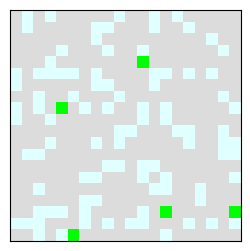

In [ ]:
#Valores de prueba
width = 20
height = 20
boxes = 100
No_agents = 5

#model = WarehouseModel(height, width, No_agents, boxes)
model = WarehouseModel2(height, width, No_agents, boxes)

#Realizar simulación
# for i in range(10000):
#   model.step()

while model.running:
    model.step()

#Visualizar datos
dataframe = model.datacollector.get_model_vars_dataframe()

fig, axs = plt.subplots(figsize=(3, 3))
axs.set_xticks([])
axs.set_yticks([])
color = plt.cm.colors.ListedColormap(['gainsboro', 'lime', "lightcyan", "paleturquoise", "turquoise", "lightseagreen", 'teal'])
patch = plt.imshow(dataframe.iloc[0, 0],animated=True, cmap=color, vmin=0, vmax=6)

def animate(i):
    patch.set_data(dataframe.iloc[i, 0])


anim = animation.FuncAnimation(fig, animate, frames=len(dataframe))

In [ ]:
anim

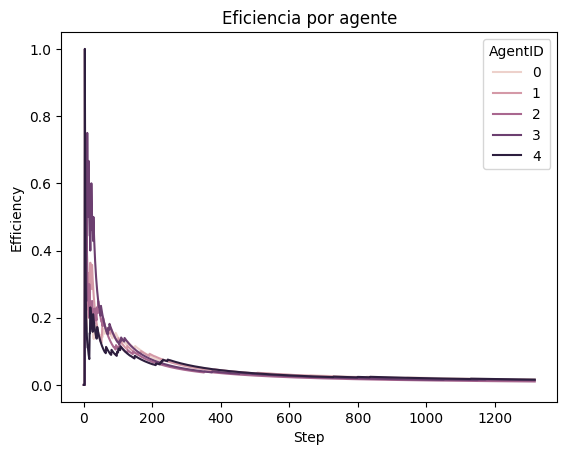

In [ ]:
agents_info=model.datacollector.get_agent_vars_dataframe()

g = sns.lineplot(data=agents_info, x="Step", y="Efficiency",
                 hue="AgentID")
g.set(title="Eficiencia por agente");

In [16]:
params = {"width": 20, "height": 20, "num_agents": 5, "num_boxes": 100}

results = batch_run(
    WarehouseModel,
    parameters = params,
    iterations = 30,
    max_steps = 20000,
    number_processes = 6,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/30 [00:00<?, ?it/s]

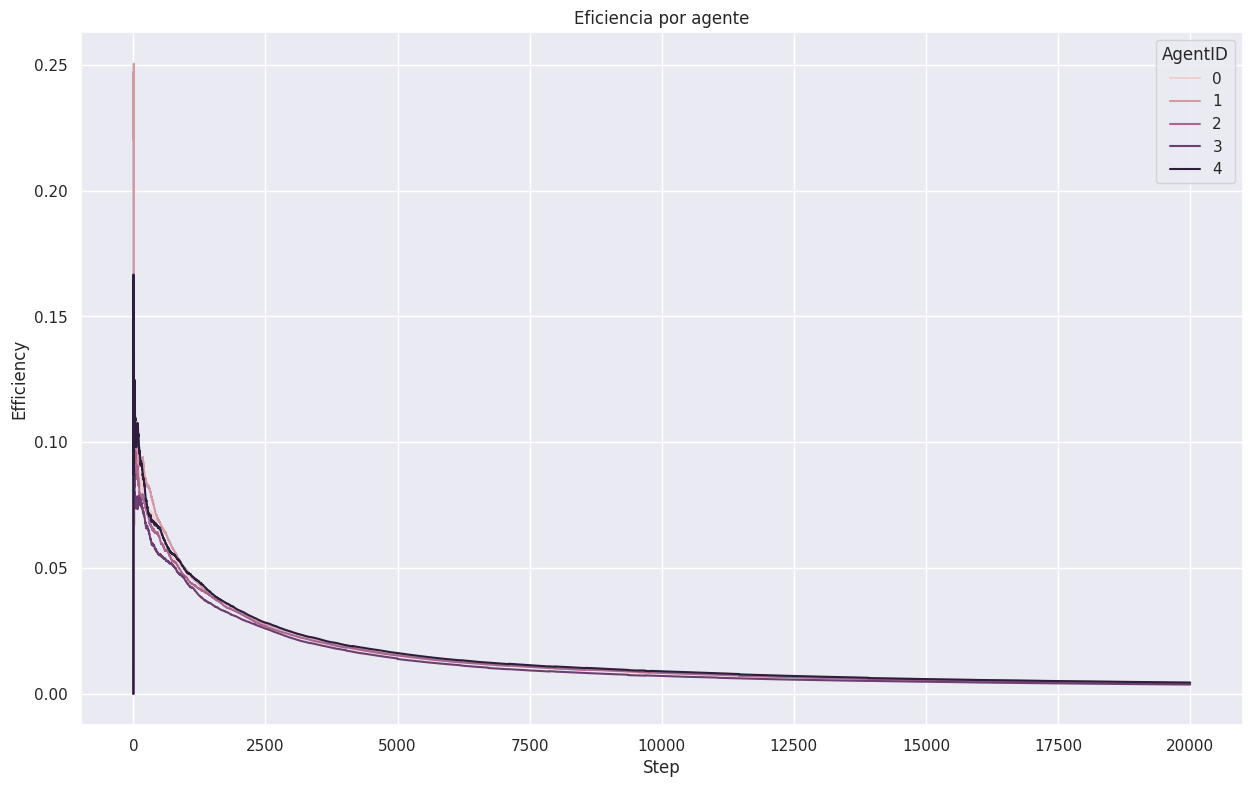

In [17]:
df = pd.DataFrame(results)
sns.set_theme(rc={'figure.figsize':(15,9)})

efficiency_df = df[["AgentID", "Step", "Efficiency"]]

agent_efficiency = efficiency_df.groupby(["AgentID", "Step"]).mean()

g = sns.lineplot(data=agent_efficiency, x="Step", y="Efficiency", hue="AgentID")
g.set(title="Eficiencia por agente")
plt.show()

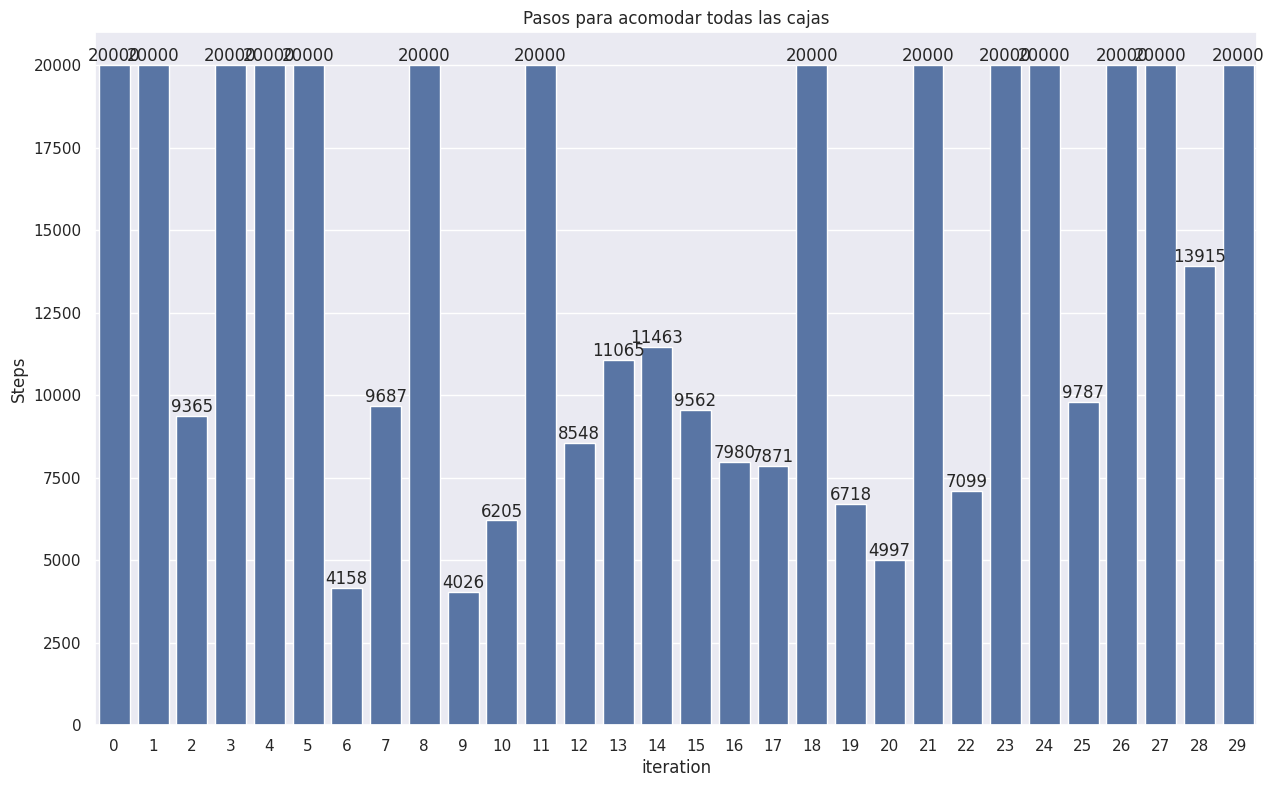

In [18]:
max_steps = df.groupby("iteration")["Steps"].max()

g = sns.barplot(data=max_steps)
g.set(title="Pasos para acomodar todas las cajas")
for i in g.containers:
    g.bar_label(i,)
plt.show()